In [1]:
# General libraries
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow/Keras for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Define database path
DB_PATH = 'database/stocks_data.db'

# Connect to the database and fetch processed stock data
def fetch_processed_data(ticker):
    """
    Fetch processed data for a specific ticker from the SQLite database.
    """
    with sqlite3.connect(DB_PATH) as conn:
        query = f"SELECT * FROM processed_stocks WHERE Ticker = '{ticker}'"
        data = pd.read_sql(query, conn)
    return data

# Specify the ticker for training
TICKER = 'AAPL'
data = fetch_processed_data(TICKER)

if data.empty:
    raise ValueError(f"No data found for ticker {TICKER} in the database.")
else:
    print(f"Data for {TICKER} fetched successfully. {data.shape[0]} rows.")


Data for AAPL fetched successfully. 6264 rows.


In [3]:
# Define features and target
features = ['MovingAverage7Day', 'MovingAverage14Day', 'Volatility', 'Lag1', 'Lag2']
target = 'Adj_Close'

# Check if all required features and target are in the data
if not set(features + [target]).issubset(data.columns):
    raise ValueError(f"Required features or target missing in the data for {TICKER}.")

# Extract features (X) and target (y)
X = data[features].values
y = data[target].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale features to range [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for LSTM [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


In [4]:
# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, len(features))),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


c:\Users\ELCACAZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 420.7083 - val_loss: 24301.0684
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 409.9046 - val_loss: 20642.9648
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 347.7727 - val_loss: 7779.5166
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.8297 - val_loss: 389.3401
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23.7294 - val_loss: 3082.2732
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19.1692 - val_loss: 2671.6621
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17.7656 - val_loss: 2766.6140
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.3323 - val_loss: 3158.3611
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 16.2595 - val_loss: 3317.4202
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.9945 - val_loss: 3590.7888
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1214 - val_loss: 3526.4253
Epoch 12/100

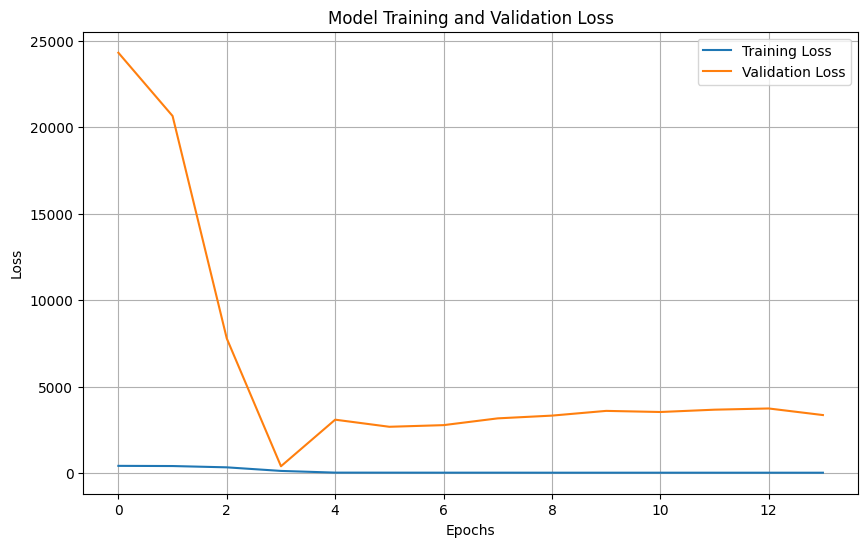

In [6]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [7]:
# Predict on the test set
y_pred = model.predict(X_test_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Evaluation:
Mean Squared Error (MSE): 389.34
Mean Absolute Error (MAE): 15.19
R-squared (R²): 0.77


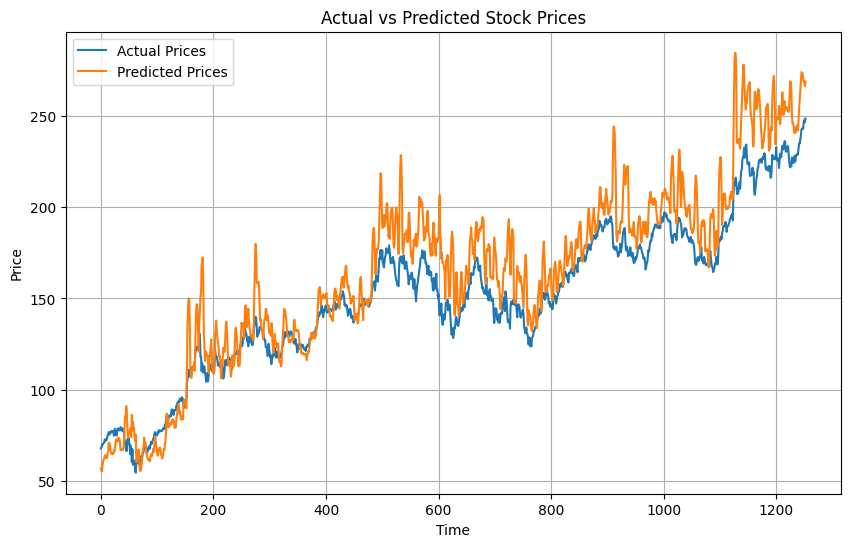

In [8]:
# Plot Actual vs Predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [9]:
import joblib

# Define paths for saving the model and scaler
model_path = f"models/model_{TICKER}_lstm.h5"
scaler_path = f"models/scaler_{TICKER}_lstm.pkl"

# Save the model
model.save(model_path)
print(f"LSTM model saved to {model_path}")

# Save the scaler
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")


LSTM model saved to models/model_AAPL_lstm.h5
Scaler saved to models/scaler_AAPL_lstm.pkl
